# COVID-19 Forecast Using DARTS for Univariate and Multivariate Time-Series Forecasting
## DS 440 

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns
from darts import TimeSeries
from darts.models import *
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.metrics import mape, smape



# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in dataset
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [3]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
# Quantify rows and columns
df.shape

(176915, 67)

In [5]:
# List of columns
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# Create different simple models for predicting number of cases for one region (I'm choosing USA)

In [6]:
# Subset data for only US data
df_us = df.loc[df['location'] == 'United States']

In [7]:
pd.set_option('display.max_rows', 500)
df_us.corr(method ='kendall')

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
total_cases,1.000000,0.332664,0.369439,0.999951,0.051405,0.108463,1.000000,0.332664,0.369495,0.999951,...,NaN,NaN,NaN,NaN,NaN,NaN,0.991505,0.702602,0.153585,0.991505
new_cases,0.332664,1.000000,0.810020,0.268940,0.490773,0.435273,0.332664,1.000000,0.810042,0.268940,...,NaN,NaN,NaN,NaN,NaN,NaN,0.267891,0.394012,0.493286,0.267891
new_cases_smoothed,0.369439,0.810020,1.000000,0.319676,0.397221,0.513803,0.369439,0.810020,0.999934,0.319676,...,NaN,NaN,NaN,NaN,NaN,NaN,0.449156,0.484192,0.533622,0.449156
total_deaths,0.999951,0.268940,0.319676,1.000000,0.051402,0.108463,0.999951,0.268940,0.319681,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.673146,0.070575,1.000000
new_deaths,0.051405,0.490773,0.397221,0.051402,1.000000,0.603485,0.051405,0.490773,0.397220,0.051402,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.174619,0.078699,0.454011,-0.174619
new_deaths_smoothed,0.108463,0.435273,0.513803,0.108463,0.603485,1.000000,0.108463,0.435273,0.513802,0.108463,...,NaN,NaN,NaN,NaN,NaN,NaN,0.131163,0.333270,0.567105,0.131163
total_cases_per_million,1.000000,0.332664,0.369439,0.999951,0.051405,0.108463,1.000000,0.332664,0.369495,0.999951,...,NaN,NaN,NaN,NaN,NaN,NaN,0.991505,0.702602,0.153585,0.991505
new_cases_per_million,0.332664,1.000000,0.810020,0.268940,0.490773,0.435273,0.332664,1.000000,0.810042,0.268940,...,NaN,NaN,NaN,NaN,NaN,NaN,0.267891,0.394012,0.493286,0.267891
new_cases_smoothed_per_million,0.369495,0.810042,0.999934,0.319681,0.397220,0.513802,0.369495,0.810042,1.000000,0.319681,...,NaN,NaN,NaN,NaN,NaN,NaN,0.448888,0.484623,0.534060,0.448888
total_deaths_per_million,0.999951,0.268940,0.319676,1.000000,0.051402,0.108463,0.999951,0.268940,0.319681,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.673146,0.070575,1.000000


In [8]:
col_list = df_us.columns
for col in col_list:
    print(col + " has " +str(df_us[col].isna().sum()) + " blank values")

iso_code has 0 blank values
continent has 0 blank values
location has 0 blank values
date has 0 blank values
total_cases has 0 blank values
new_cases has 1 blank values
new_cases_smoothed has 7 blank values
total_deaths has 38 blank values
new_deaths has 39 blank values
new_deaths_smoothed has 51 blank values
total_cases_per_million has 0 blank values
new_cases_per_million has 1 blank values
new_cases_smoothed_per_million has 7 blank values
total_deaths_per_million has 38 blank values
new_deaths_per_million has 39 blank values
new_deaths_smoothed_per_million has 51 blank values
reproduction_rate has 46 blank values
icu_patients has 176 blank values
icu_patients_per_million has 176 blank values
hosp_patients has 176 blank values
hosp_patients_per_million has 176 blank values
weekly_icu_admissions has 806 blank values
weekly_icu_admissions_per_million has 806 blank values
weekly_hosp_admissions has 182 blank values
weekly_hosp_admissions_per_million has 182 blank values
total_tests has 4

In [9]:
df_us.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
166657,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
166658,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
166659,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
166660,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
166661,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8926.0,-3.59,-2.63,-26.811643


In [10]:
# Subset for only the dates and total_cases columns

df_us_cases = df_us[['date', 'total_cases']]
df_us_deaths = df_us[['date', 'total_deaths']]
df_us_cases.head()

,date,total_cases
166657,2020-01-22,1.0
166658,2020-01-23,1.0
166659,2020-01-24,2.0
166660,2020-01-25,2.0
166661,2020-01-26,5.0


In [11]:
df_us_cases = df_us_cases.dropna()
df_us_deaths = df_us_deaths.dropna()
print(df_us_cases['total_cases'].isnull().sum())
print(df_us_cases['total_cases'].isna().sum())
print(df_us_deaths['total_deaths'].isnull().sum())
print(df_us_deaths['total_deaths'].isna().sum())

0
0
0
0


In [12]:
df_us_cases.tail()

,date,total_cases
167458,2022-04-02,80150811.0
167459,2022-04-03,80155397.0
167460,2022-04-04,80179289.0
167461,2022-04-05,80208810.0
167462,2022-04-06,80248986.0


In [13]:
# Need to set the date col to be a df index and format the date column to a date type
df_us_cases.index = pd.to_datetime(df_us_cases['date'], format='%Y-%m-%d')
df_us_deaths.index = pd.to_datetime(df_us_deaths['date'], format='%Y-%m-%d')

In [14]:
df_us_cases2 = df_us_cases[df_us_cases.index >= pd.to_datetime('2021-09-01', format='%Y-%m-%d')]

In [15]:
# Split the data into a training and testing set
# Training will be all data before December 2021 and Testing will be all data since then
train_cases = df_us_cases[df_us_cases.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test_cases = df_us_cases[df_us_cases.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
train_cases2 = df_us_cases2[df_us_cases2.index < pd.to_datetime('2022-03-01', format='%Y-%m-%d')]
test_cases2 = df_us_cases2[df_us_cases2.index >= pd.to_datetime('2022-03-01', format='%Y-%m-%d')]
train_deaths = df_us_deaths[df_us_deaths.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test_deaths = df_us_deaths[df_us_deaths.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]


In [16]:
train_cases.reset_index(drop=True, inplace=True)
test_cases.reset_index(drop=True, inplace=True)
train_cases2.reset_index(drop=True, inplace=True)
test_cases2.reset_index(drop=True, inplace=True)
train_deaths.reset_index(drop=True, inplace=True)
test_deaths.reset_index(drop=True, inplace=True)

In [17]:
cases_series = TimeSeries.from_dataframe(df_us_cases, 'date', 'total_cases')
train_cases_series = TimeSeries.from_dataframe(train_cases, 'date', 'total_cases')
test_cases_series = TimeSeries.from_dataframe(test_cases, 'date', 'total_cases')


cases_series2 = TimeSeries.from_dataframe(df_us_cases2, 'date', 'total_cases')
train_cases_series2 = TimeSeries.from_dataframe(train_cases2, 'date', 'total_cases')
test_cases_series2 = TimeSeries.from_dataframe(test_cases2, 'date', 'total_cases')

deaths_series = TimeSeries.from_dataframe(df_us_deaths, 'date', 'total_deaths')
train_deaths_series = TimeSeries.from_dataframe(train_deaths, 'date', 'total_deaths')
test_deaths_series = TimeSeries.from_dataframe(test_deaths, 'date', 'total_deaths')

# Just using a simple Exponential Smoothing Model for Univariate

In [18]:
model = ExponentialSmoothing()
model.fit(train_cases_series)
prediction = model.predict(len(test_cases_series)+90, num_samples=1000)

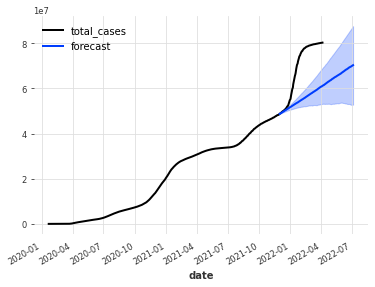

In [19]:
cases_series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]

In [20]:
model = ExponentialSmoothing()
model.fit(train_cases_series2)
prediction = model.predict(len(test_cases_series2)+90, num_samples=1000)

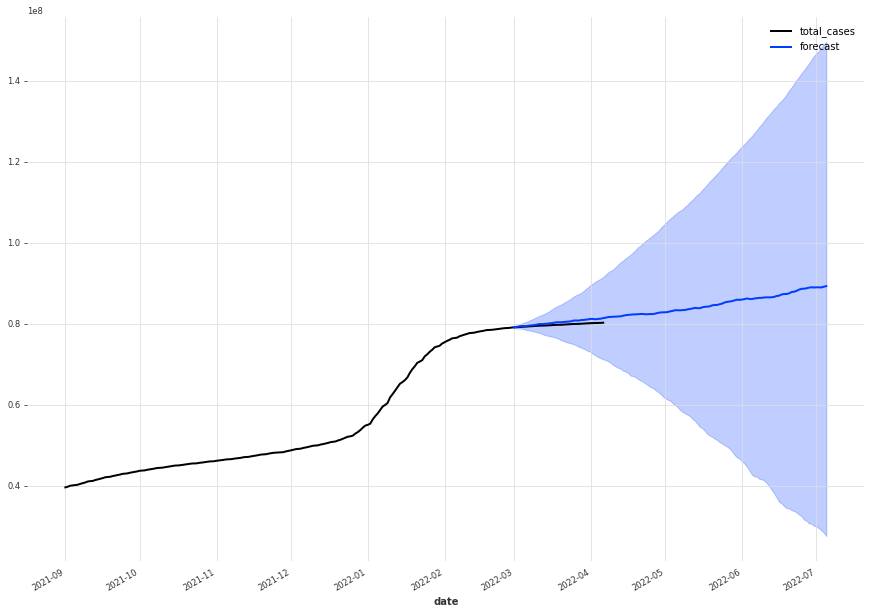

In [21]:
cases_series2.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]

In [22]:
model = ExponentialSmoothing()
model.fit(train_deaths_series)
prediction = model.predict(len(test_deaths_series)+60, num_samples=1000)

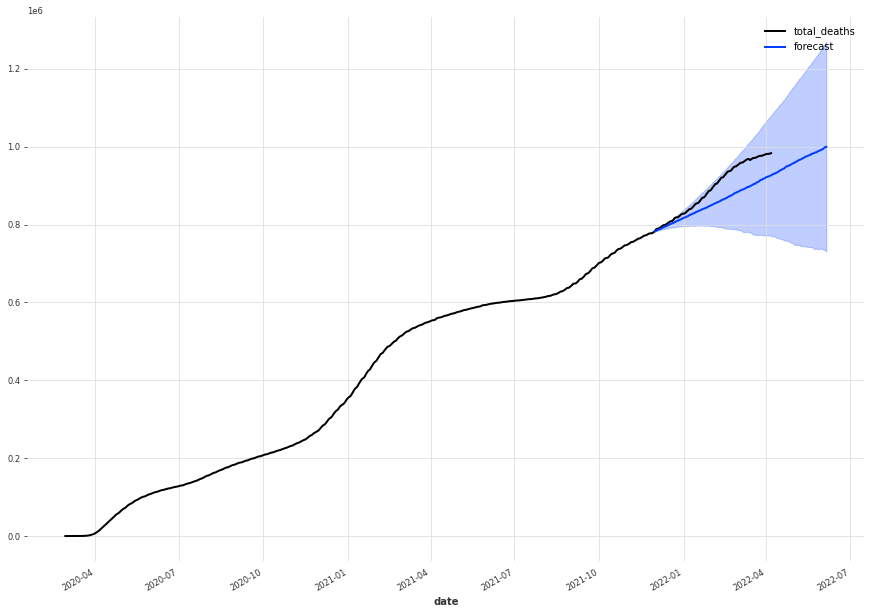

In [23]:
deaths_series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]

# Attempting Multivariate Time Series Modeling utilizing a function to combine multiple variables

In [24]:
# List of columns
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [25]:
df_us_total_cases = df_us[['date', 'total_cases']]
df_us_total_vaccinations = df_us[['date', 'total_vaccinations']]
df_us_total_boosters = df_us[['date', 'total_boosters']]
df_us_total_deaths = df_us[['date', 'total_deaths']]
df_us_positive_rate = df_us[['date', 'positive_rate']]
df_us_new_cases = df_us[['date', 'new_cases']]
df_us_new_deaths = df_us[['date', 'new_deaths']]
df_us_reproduction_rate = df_us[['date', 'reproduction_rate']]
df_us_icu_patients = df_us[['date', 'icu_patients']]
df_us_hosp_patients = df_us[['date', 'hosp_patients']]
df_us_total_tests = df_us[['date', 'total_tests']]
df_us_new_tests = df_us[['date', 'new_tests']]
df_us_tests_per_case = df_us[['date', 'tests_per_case']]
df_us_people_fully_vaccinated = df_us[['date', 'people_fully_vaccinated']]
df_us_new_vaccinations = df_us[['date', 'new_vaccinations']]
df_us_stringency_index = df_us[['date', 'stringency_index']]
df_us_gdp_per_capita = df_us[['date', 'gdp_per_capita']]
df_us_female_smokers = df_us[['date', 'female_smokers']]
df_us_male_smokers = df_us[['date', 'male_smokers']]
df_us_life_expectancy = df_us[['date', 'life_expectancy']]
df_us_median_age = df_us[['date', 'median_age']]
df_us_cardiovasc_death_rate = df_us[['date', 'cardiovasc_death_rate']]

In [26]:
# replace na values with 0
df_us_total_boosters['total_boosters'] = df_us_total_boosters['total_boosters'].fillna(0)
df_us_total_vaccinations['total_vaccinations'] = df_us_total_vaccinations['total_vaccinations'].fillna(0)
df_us_positive_rate['positive_rate'] = df_us_positive_rate['positive_rate'].fillna(0)
df_us_total_cases['total_cases'] = df_us_total_cases['total_cases'].fillna(0)
df_us_total_deaths['total_deaths'] = df_us_total_deaths['total_deaths'].fillna(0)
df_us_new_cases['new_cases'] = df_us_new_cases['new_cases'].fillna(0)
df_us_new_deaths['new_deaths'] = df_us_new_deaths['new_deaths'].fillna(0)
#df_us_reproduction_rate['reproduction_rate'] = df_us_reproduction_rate['reproduction_rate'].fillna(0)
df_us_icu_patients['icu_patients'] = df_us_icu_patients['icu_patients'].fillna(0)
df_us_hosp_patients['hosp_patients'] = df_us_hosp_patients['hosp_patients'].fillna(0)
df_us_new_tests['new_tests'] = df_us_new_tests['new_tests'].fillna(0)
df_us_tests_per_case['tests_per_case'] = df_us_tests_per_case['tests_per_case'].fillna(0)
df_us_people_fully_vaccinated['people_fully_vaccinated'] = df_us_people_fully_vaccinated['people_fully_vaccinated'].fillna(0)
df_us_new_vaccinations['new_vaccinations'] = df_us_new_vaccinations['new_vaccinations'].fillna(0)
#df_us_stringency_index['stringency_index'] = df_us_stringency_index['stringency_index'].fillna(0)
#df_us_gdp_per_capita['gdp_per_capita'] = df_us_gdp_per_capita['gdp_per_capita'].fillna(0)
#df_us_female_smokers['female_smokers'] = df_us_female_smokers['female_smokers'].fillna(0)
#df_us_male_smokers['male_smokers'] = df_us_male_smokers['male_smokers'].fillna(0)
#df_us_life_expectancy['life_expectancy'] = df_us_life_expectancy['life_expectancy'].fillna(0)
#df_us_median_age['median_age'] = df_us_median_age['median_age'].fillna(0)
df_us_cardiovasc_death_rate['cardiovasc_death_rate'] = df_us_cardiovasc_death_rate['cardiovasc_death_rate'].fillna(0)

In [27]:
total_boosters_series = TimeSeries.from_dataframe(df_us_total_boosters, 'date', 'total_boosters')
total_vaccinations_series = TimeSeries.from_dataframe(df_us_total_vaccinations, 'date', 'total_vaccinations')
total_cases_series = TimeSeries.from_dataframe(df_us_total_cases, 'date', 'total_cases')
total_deaths_series = TimeSeries.from_dataframe(df_us_total_deaths, 'date', 'total_deaths')
positive_rate_series = TimeSeries.from_dataframe(df_us_positive_rate, 'date', 'positive_rate')
new_cases_series = TimeSeries.from_dataframe(df_us_new_cases, 'date', 'new_cases')
new_deaths_series = TimeSeries.from_dataframe(df_us_new_deaths, 'date', 'new_deaths')
#reproduction_rate_series = TimeSeries.from_dataframe(df_us_reproduction_rate, 'date', 'reproduction_rate')
icu_patients_series = TimeSeries.from_dataframe(df_us_icu_patients, 'date', 'icu_patients')
hosp_patients_series = TimeSeries.from_dataframe(df_us_hosp_patients, 'date', 'hosp_patients')
new_tests_series = TimeSeries.from_dataframe(df_us_new_tests, 'date', 'new_tests')
tests_per_case_series = TimeSeries.from_dataframe(df_us_tests_per_case, 'date', 'tests_per_case')
people_fully_vaccinated_series = TimeSeries.from_dataframe(df_us_people_fully_vaccinated, 'date', 'people_fully_vaccinated')
new_vaccinations_series = TimeSeries.from_dataframe(df_us_new_vaccinations, 'date', 'new_vaccinations')
#stringency_index_series = TimeSeries.from_dataframe(df_us_stringency_index, 'date', 'stringency_index')
#gdp_per_capita_series = TimeSeries.from_dataframe(df_us_gdp_per_capita, 'date', 'gdp_per_capita')
#female_smokers_series = TimeSeries.from_dataframe(df_us_female_smokers, 'date', 'female_smokers')
#male_smokers_series = TimeSeries.from_dataframe(df_us_male_smokers, 'date', 'male_smokers')
#life_expectancy_series = TimeSeries.from_dataframe(df_us_life_expectancy, 'date', 'life_expectancy')
#median_age_series = TimeSeries.from_dataframe(df_us_median_age, 'date', 'median_age')
cardiovasc_death_rate_series = TimeSeries.from_dataframe(df_us_cardiovasc_death_rate, 'date', 'cardiovasc_death_rate')


In [28]:
scaler = Scaler()
series_total_cases_scaled = scaler.fit_transform(total_cases_series)
series_total_deaths_scaled = scaler.fit_transform(total_deaths_series)
series_total_boosters_scaled = scaler.fit_transform(total_boosters_series)
series_total_vaccinations_scaled = scaler.fit_transform(total_vaccinations_series)
series_positive_rate_scaled = scaler.fit_transform(positive_rate_series)

series_new_cases_scaled = scaler.fit_transform(new_cases_series)
series_new_deaths_scaled = scaler.fit_transform(new_deaths_series)
#series_reproduction_rate_scaled = scaler.fit_transform(reproduction_rate_series)
series_icu_patients_scaled = scaler.fit_transform(icu_patients_series)
series_hosp_patients_scaled = scaler.fit_transform(hosp_patients_series)
series_new_tests_scaled = scaler.fit_transform(new_tests_series)
series_tests_per_case_scaled = scaler.fit_transform(tests_per_case_series)
series_people_fully_vaccinated_scaled = scaler.fit_transform(people_fully_vaccinated_series)
series_new_vaccinations_scaled = scaler.fit_transform(new_vaccinations_series)
#series_stringency_index_scaled = scaler.fit_transform(stringency_index_series)
#series_gdp_per_capita_scaled = scaler.fit_transform(gdp_per_capita_series)
#series_female_smokers_scaled = scaler.fit_transform(female_smokers_series)
#series_male_smokers_scaled = scaler.fit_transform(male_smokers_series)
#series_life_expectancy_scaled = scaler.fit_transform(life_expectancy_series)
#series_median_age_scaled = scaler.fit_transform(median_age_series)
series_cardiovasc_death_rate_scaled = scaler.fit_transform(cardiovasc_death_rate_series)



In [29]:
train_total_cases, val_total_cases = series_total_cases_scaled[:-36], series_total_cases_scaled[-36:]
train_total_deaths, val_total_deaths = series_total_deaths_scaled[:-36], series_total_deaths_scaled[-36:]
train_total_boosters, val_total_boosters = series_total_boosters_scaled[:-36], series_total_boosters_scaled[-36:]
train_total_vaccinations, val_total_vaccinations = series_total_vaccinations_scaled[:-36], series_total_vaccinations_scaled[-36:]
train_positive_rate, val_positive_rate = series_positive_rate_scaled[:-36], series_positive_rate_scaled[-36:]

train_new_cases, val_new_cases = series_new_cases_scaled[:-36], series_new_cases_scaled[-36:]
train_new_deaths, val_new_deaths = series_new_deaths_scaled[:-36], series_new_deaths_scaled[-36:]
#train_reproduction_rate, val_reproduction_rate = series_reproduction_rate_scaled[:-36], series_reproduction_rate_scaled[-36:]
train_icu_patients, val_icu_patients = series_icu_patients_scaled[:-36], series_icu_patients_scaled[-36:]
train_hosp_patients, val_hosp_patients = series_hosp_patients_scaled[:-36], series_hosp_patients_scaled[-36:]
train_new_tests, val_new_tests = series_new_tests_scaled[:-36], series_new_tests_scaled[-36:]
train_tests_per_case, val_positive_rate = series_positive_rate_scaled[:-36], series_positive_rate_scaled[-36:]
train_people_fully_vaccinated, val_people_fully_vaccinated = series_people_fully_vaccinated_scaled[:-36], series_people_fully_vaccinated_scaled[-36:]
train_new_vaccinations, val_new_vaccinations = series_new_vaccinations_scaled[:-36], series_new_vaccinations_scaled[-36:]
#train_stringency_index, val_stringency_index = series_stringency_index_scaled[:-36], series_stringency_index_scaled[-36:]
#train_gdp_per_capita, val_gdp_per_capita = series_gdp_per_capita_scaled[:-36], series_gdp_per_capita_scaled[-36:]
#train_female_smokers, val_female_smokers = series_female_smokers_scaled[:-36], series_female_smokers_scaled[-36:]
#train_male_smokers, val_male_smokers = series_male_smokers_scaled[:-36], series_male_smokers_scaled[-36:]
#train_life_expectancy, val_life_expectancy = series_life_expectancy_scaled[:-36], series_life_expectancy_scaled[-36:]
#train_median_age, val_median_age = series_median_age_scaled[:-36], series_median_age_scaled[-36:]
train_cardiovasc_death_rate, val_cardiovasc_death_rate = series_cardiovasc_death_rate_scaled[:-36], series_cardiovasc_death_rate_scaled[-36:]



In [32]:
model_mvts = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=10)

In [34]:
model_mvts.fit(train_total_cases, verbose=True)

[2022-04-07 15:19:47,027] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-04-07 15:19:47,027] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-04-07 15:19:47,123] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-07 15:19:47,123] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-07 15:19:47,124] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-04-07 15:19:47,124] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Training: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

MAPE = 0.43%


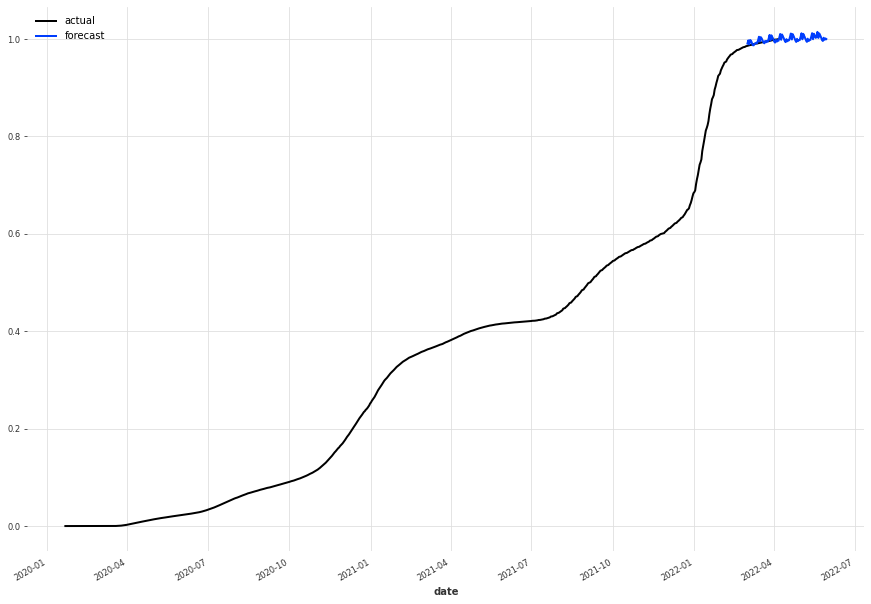

In [35]:
pred = model_mvts.predict(n=90, series=train_total_cases, num_samples=1000)

series_total_cases_scaled.plot(label='actual')
pred.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend();
plt.rcParams['figure.figsize'] = [15, 10]
print('MAPE = {:.2f}%'.format(mape(series_total_cases_scaled, pred)))

In [36]:
model_mvts.fit(train_total_deaths, verbose=True)

[2022-04-07 15:21:27,816] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-04-07 15:21:27,816] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-04-07 15:21:27,826] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-04-07 15:21:27,826] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creati

Training: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

MAPE = 1.46%


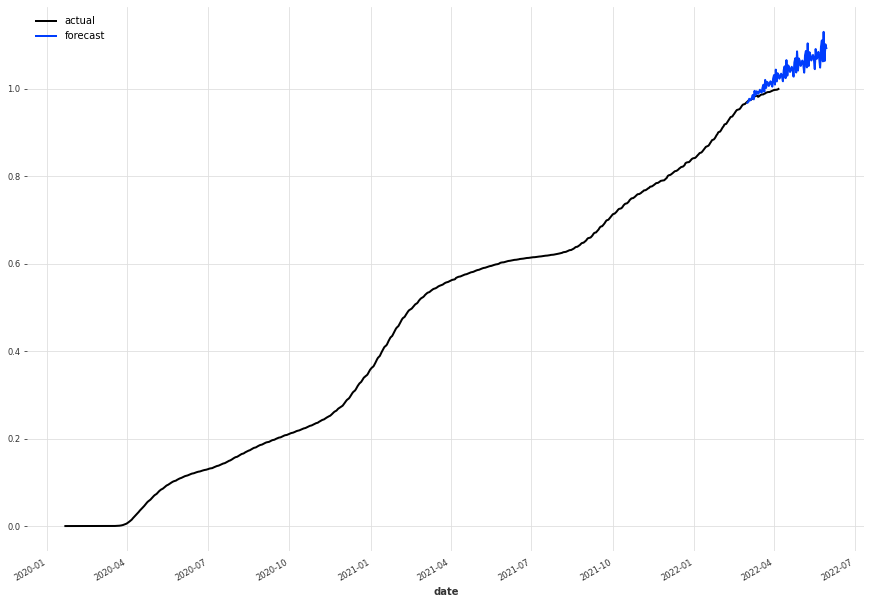

In [37]:
pred = model_mvts.predict(n=90, series=train_total_deaths, num_samples=1000)

series_total_deaths_scaled.plot(label='actual')
pred.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend();
plt.rcParams['figure.figsize'] = [15, 10]
print('MAPE = {:.2f}%'.format(mape(series_total_deaths_scaled, pred)))

In [55]:
model_mvts = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=10)
model_mvts.fit([train_total_deaths, train_total_boosters, train_total_vaccinations], verbose=True)

[2022-04-07 15:43:04,234] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2205 samples.
[2022-04-07 15:43:04,234] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2205 samples.
[2022-04-07 15:43:04,298] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-07 15:43:04,298] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-07 15:43:04,299] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-04-07 15:43:04,299] WARNING | darts.models.forecasting.torch_forecasting_model | Depre

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

MAPE = 0.45%


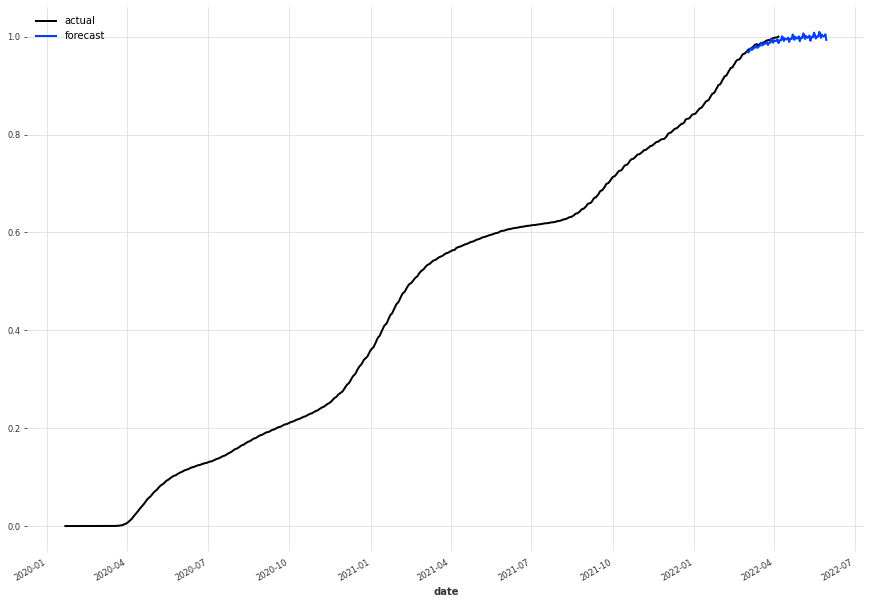

In [56]:
pred = model_mvts.predict(n=90, series=train_total_deaths, num_samples=1000)

series_total_deaths_scaled.plot(label='actual')
pred.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend();
plt.rcParams['figure.figsize'] = [15, 10]
print('MAPE = {:.2f}%'.format(mape(series_total_deaths_scaled, pred)))